In [15]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import math 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.rolling import RollingOLS
from statsmodels.datasets import longley
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pmd
from pygam import LinearGAM, PoissonGAM, l, s, f, te
from pandas.plotting import autocorrelation_plot

# History
Referenced in academia over two centuries ago and built on concepts of random processes, the analysis of time-indexed data arose as a necessary tool for future predicitons. In fact, recorded utiliztion of time series forecasting dates back to the 17th century, when doctors in London attempted to forecast death numbers for future years based on historical data in an attempt to decide hiring patterns, resource allocation, etc. This article seeks to provide an introduction to the necessary concepts within Time Series Forecasting. 

In summary, time series data is simply observations taken at a certain point and indexed by that time - keep in mind that time series is just a sequence of well-defined data points measured at consistent time intervals over a period of time. The benefits of time series include an understanding of hidden patterns, meaningful characteristics of the data, and possible trends that may aid in future predicitons.  

**Yes, all of this statistical theory is interesting, but why should you care? Why is the term "time series" so prevalant within both academic and professional circles today?** In fact, time series is everywhere. There are an innumerable number of domains and fields where time series analysis is utilized, but I hope that the few listed above provide sufficient motivation for a deeper dive into this topic.

**Finally, what is the difference between time series and datasets not indexed by time?** Non-time indexed data is coined "cross-sectional data" - we can imagine that the data came from a slice in time. In contrast with time series, a cross-section looks at a single point in time, which is useful for comparing and analyzing the effect of different factors on one another or describing a sample. One can analogize time series to taking repeated samples of the same quantatative data over time. In practice, both forms of analysis are commonly used; and when available, are used together!

# Data

For this project, we will be working with three datasets, each contaning time-indexed observations of sales, home price sales, listings, and inventory for 18 different American countiues over a 10-year span. Observations are taken with intervals spanning a month; below is an excerpt from the final merged dataframe that we will be working with:

In [16]:
## import & concat out three housing datasets
path = '/Users/andrewma/Desktop/Stat-Notes/data/'
df = pd.concat(map(pd.read_csv, [path + 'texas_counties1.csv', path + 'texas_counties2.csv', path + 'texas_counties3.csv']))

#remove 2 rows of NaN in 'sales','dollar_vol','avg_price','med_price']
df.columns[df.isna().any()].tolist()
df.loc[:, df.isnull().any()]
df = df[-df['avg_price'].isna()]
df.head(5)

,Unnamed: 0,date,sales,dollar_vol,avg_price,med_price,total_listings,month_inventory,county
0,0,Jan 2011,15,"1,122,600","74,840","50,000",344,31.0,Anderson
1,1,Feb 2011,20,"1,652,300","82,615","66,950",371,30.1,Anderson
2,2,Mar 2011,25,"3,013,550","120,542","92,000",372,27.1,Anderson
3,3,Apr 2011,25,"2,733,350","109,334","115,000",365,24.1,Anderson
4,4,May 2011,27,"2,239,161","82,932","70,000",387,23.8,Anderson


## Data Collection & Cleaning

There are a couple of data preprocessing steps we must undertake:

- examine the object 'type' of each column to ensure that we are indexed by datetime & numerics are converted to int/float
- remove the two empty rows in the 'sales' and 'dollar_vol' columns
- since there are ~2000 missing values in total_listings and month_inventory, let's impute them with the mean values of their respective column

In [17]:
df.dtypes

Unnamed: 0           int64
date                object
sales               object
dollar_vol          object
avg_price           object
med_price           object
total_listings      object
month_inventory    float64
county              object
dtype: object

In [18]:
## clean up commas & convert strings to float
str_cols = ['sales', 'dollar_vol', 'avg_price', 'med_price', 'total_listings', 'month_inventory']
df[str_cols] = df[str_cols].replace(',', '', regex=True)
df[str_cols] = df[str_cols].apply(pd.to_numeric, errors='coerce')
#remove 'Unnamed:0' column as it simply is another index for the month
df = df.drop(columns='Unnamed: 0')

#convert date column to datetime format & sort
df['date'] = pd.to_datetime(df['date'])

In [19]:
## clean dataset & impute missing values 
## impute missing values with probabilistic mean PCA
df.fillna(1, inplace=True)

## the two coluumns which contain ~2k missing values
total = df['total_listings'].values.reshape(1, -1)
month = df['month_inventory'].values.reshape(1, -1)

## implementation of SimpleImputer model 
imp_mean = SimpleImputer(missing_values = 1, strategy='mean')
imp_mean.fit(month); imp_mean.transform(month)
imp_mean.fit(total); imp_mean.transform(total)

month_filler = np.transpose(pd.DataFrame(imp_mean.transform(month)))
total_filler = np.transpose(pd.DataFrame(imp_mean.transform(total)))
df['total_listings'] = total_filler
df['month_inventory'] = month_filler


## Data Exploration & Visualization

To acquire a better understanding of the data, let's explore the number of home sales Austin, Texas. An overall upward trend can be observed from the years 2001 to 2007, followed by a fluctuation from 2008 to mid-2010. Starting in 2011, there seems to be consistent fluctuations with a clear downturn in 2020. We can say pretty confidently that the house market crash in 2008 and the consequences of Covid-measures were the causes of these fluctutions; however, we do not want to skip these periods as that would risk an overfit model as a result of limited data points.

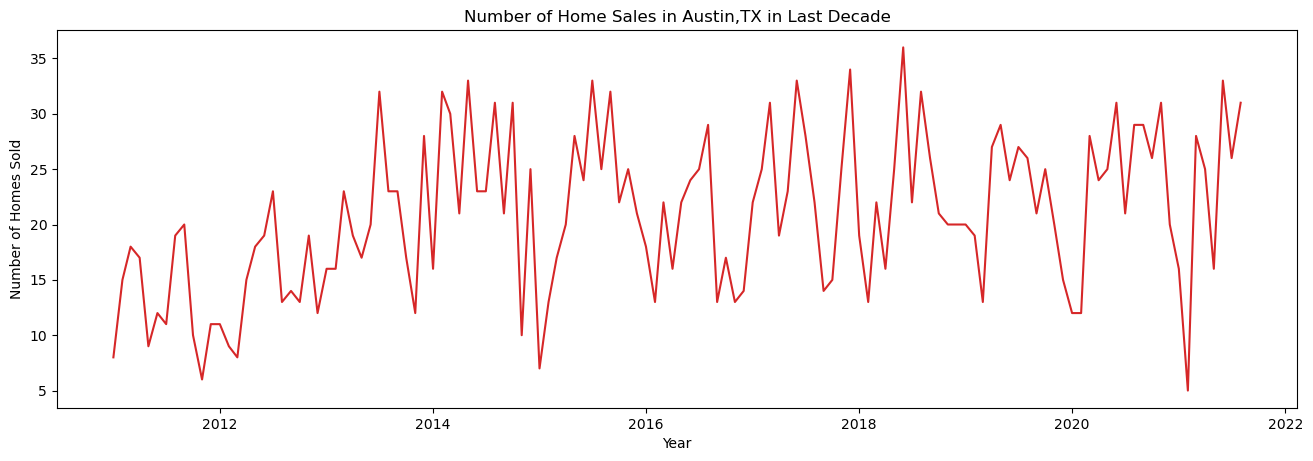

In [20]:
## modeling variances of average home prices
## pull out county consisting of high variance
austin = df[df['county'] == 'Austin']

## Prepare data
austin['year'] = [d.year for d in austin.date]
austin['month'] = [d.strftime('%b') for d in austin.date]
years = austin['year'].unique()

## basic time series plot
def plot_df(df, x, y, title="", xlabel='Year', ylabel='Number of Homes Sold', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel='Number of Homes Sold')
    plt.show()

plot_df(df, x=austin.date, y=austin.sales, title='Number of Home Sales in Austin,TX in Last Decade') 

In [21]:
## predefine features & labels
features = ['dollar_vol','avg_price','med_price','total_listings','month_inventory']
target = ['sales']

## normalize data as there is a large absolute difference between many of the predcitors which will result in 
## disproportionally large weights for some of the covariates 
minmax = MinMaxScaler()
df[target] = minmax.fit_transform(df[target])
df[features] = minmax.fit_transform(df[features])

## sort by date and make sure no null values are left
df = df.sort_values(by=['date'])
df = df.dropna()

### ANOVA

### Stationary Behavior

With respect to stationary behavior, time dependent variables can either be classified as **weakly stationary** or **strict stationary**; these properties allow us to account for the estimate the statistical properties of our time series, such as mean, variance, standard deviation, e.t.c. In a sentence, **time series are stationary if they do not have trend or seasonal effects**. The importance of stationality lies in the fact that many forecasting methods require as assumption of stationary behavior; ie, we need to have have an idea of the long-term behavior of our time series.

To test the stationary properties of our time series, we can apply the **Augmented Dickey-Fuller unit root test** (AD-test), which is a hypothesis test for:

$H_0: Time \ Series\ T \ is \ not \ stationary$

$H_1: T\  is  \ stationary$

In [8]:
time = df[['date','sales']]
result = adfuller((austin['sales']))

## print ADF test results
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.022673030682679
p-value: 2.0010797024219305e-05
Critial Values:
   1%, -3.4833462346078936
Critial Values:
   5%, -2.8847655969877666
Critial Values:
   10%, -2.5791564575459813


With a test statistic of -5.022673030682679 and a p-value of 2.0010797024219305e-05, **we can reject the null hypothesis and assume that the residuals associated with the number of sales is stationary**; in other words, there the resuiduals have a asymptotic mean and varaince that can be estimated & incorporated into our models.

For nonstationary time series, many options exist for the conversion of Non-stationary into stationary for effective time series modeling. There are two major methods available for this conversion:

1. Detrending - removing the trend effects from the given dataset and showing only the differences in values from the trend. it always allows the cyclical patterns to be identified.
   
2. Differencing - simple transformation of the series used to remove the series dependence on time and stabilize the mean of the time series, so trend and seasonality are reduced during this transformation.
   
3. Transformation - Transofrmation include the Power Transform, Square Root, and Log Transfer - often, log-transformations result in normalization of our observations, and thus stationary behavior

Most computational models feature parameters which allow for the stationary conversion of any time-indexed series with the inclusion of a lag and differencing parameter; for example, one is able to feed a non-stationary time-series into the ARIMA model alongside degrees of differencing. We will go into more detail about how these parameters in the model implementation seciton below. 

### Seasonality

Next, let's attempt to decipher the contribution of seasonality to our time series by exploring the number of home sales after grouping by month and year; **seasonality is simply a noticeable cycle that repeats over time, such as monthly or yearly**. We wish to obscure or remove this effect as seasonality may induce large bias in our forecasting models; in this instance, we may see large spikes for summer months when home sales are higher than winter months. As with the proerties of stationary time series, one popular method to remove this seasonality component is the difference method, which can similiarly be incorporated as a parameter within our model hyperparameters. However, note that **seasonality is subjective**, and it is best to explore the data over multiple time intervals or to decompose the series to acquire a better understanding of its behavior.

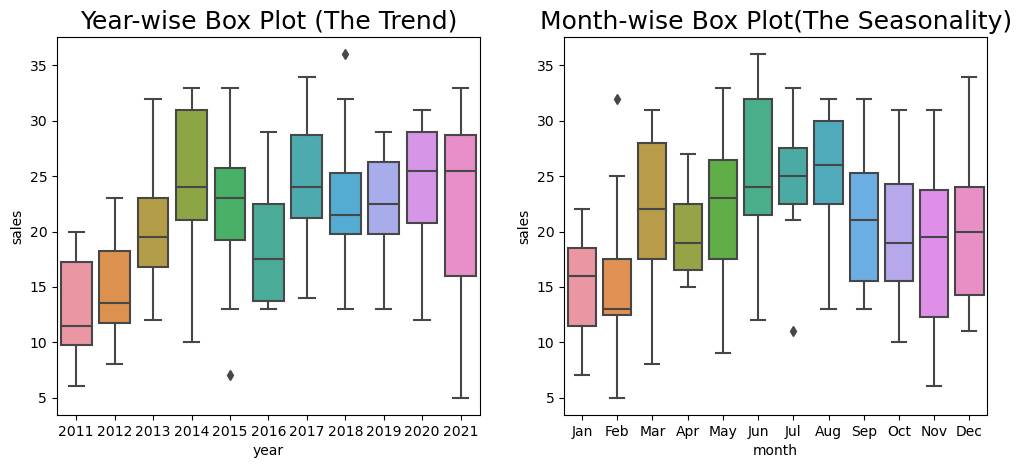

In [9]:
## Boxplots for Seasonality trend 
fig, axes = plt.subplots(1,2,figsize=(12,5), dpi= 100)

## year-wise boxplot
sns.boxplot(x='year', y= 'sales', data=austin, ax=axes[0])

## boxplot based on month - explore seasonal trends
sns.boxplot(x='month', y='sales', data=austin.loc[~austin.year.isin([1991, 2008]), :])

## plot title & options
axes[0].set_title('Year-wise Box Plot (The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot(The Seasonality)', fontsize=18)
plt.show()

### Time Series Decomposition

Time series decomposition involves the transfomration of a time series into a combination of level, trend, seasonality, and noise components - it provides a structured way of thinking about a time series forecasting problem, both with respect to modeling complexity/specifically and the optimal parameters of our models. Each of these components are something you may need to think about and address during data preparation, model selection, and model tuning. You may address it explicitly in terms of modeling the trend and subtracting it from your data, or implicitly by providing enough history for an algorithm to model a trend if it may exist. Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting. While there exist numerous methods of deomposition, we will review two popular and simple ones: 

- Additive time series: Value = Base Level + Trend + Seasonality + Error - good when seasonal changes are constant year to year; i.e., spike in store sales around holidays

- Multiplicative Time Series: Value = Base Level $\times$ Trend $\times$ Seasonality $\times$ Error - this is good for models where there is seasonal variability over time

Of course, the way to de-trend the data needs to additive or multiplicative depending on what type your time series is - which decomposition makes more sense? **Since we don’t know the type of time series at this point, we’ll decompose the sales aspect both ways**. 

Right away, we notice that the multiplicative decompoisiton results in residuals not able to be attributed to white noise, or inherent system randomness. Thus, the additive decomposition of 'sales' better reflects the proper breakdown of our given time series; note that there is a clear increasing trend and constant fluctuation seasonality. In combination with residuals that appear normally distributed with a mean of 0, additive decomposition tells us that linear - additive models may provide better predicitons than multiplicative ones.

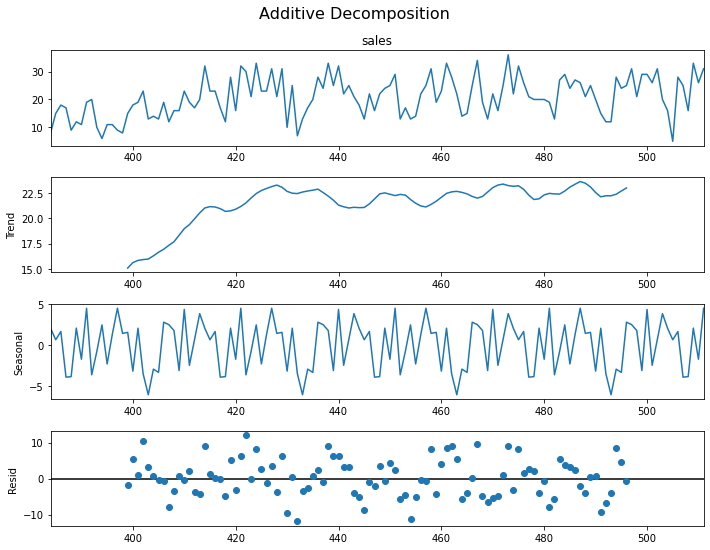

In [10]:
## Decomposition of Time Series
## Additive Decomposition
plt.rcParams.update({'figure.figsize': (10,8)})
additive_decomposition = seasonal_decompose(austin['sales'], model='additive', period=30)

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


On the other hand, multiplicative decomposition results in the prescence of heteroscedascity within our reisduals - there are unexplainable & unaccountable factors which influence our time series. This means that we are always unsure of our predicitions, resulting in theoretically large biases within our model predicitions. 

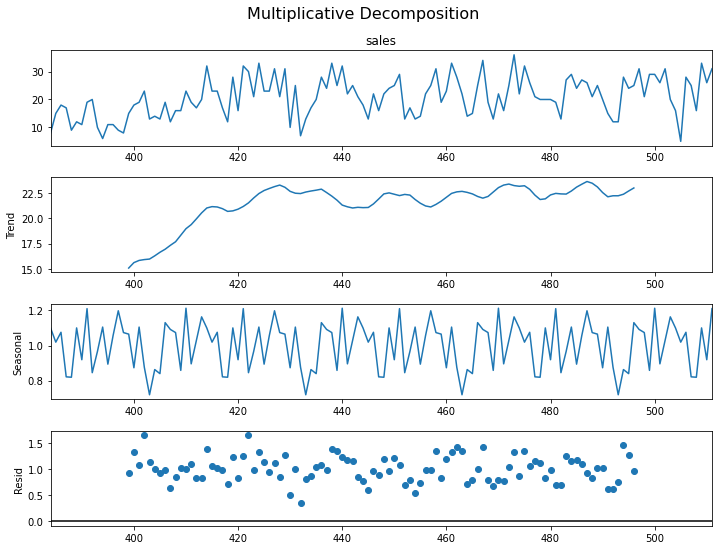

In [11]:
## Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(austin['sales'], model='multiplicative', period=30)

## M-decomposition plot
plt.rcParams.update({'figure.figsize': (10,8)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

### Autocorrelation



(-0.25, 0.25)

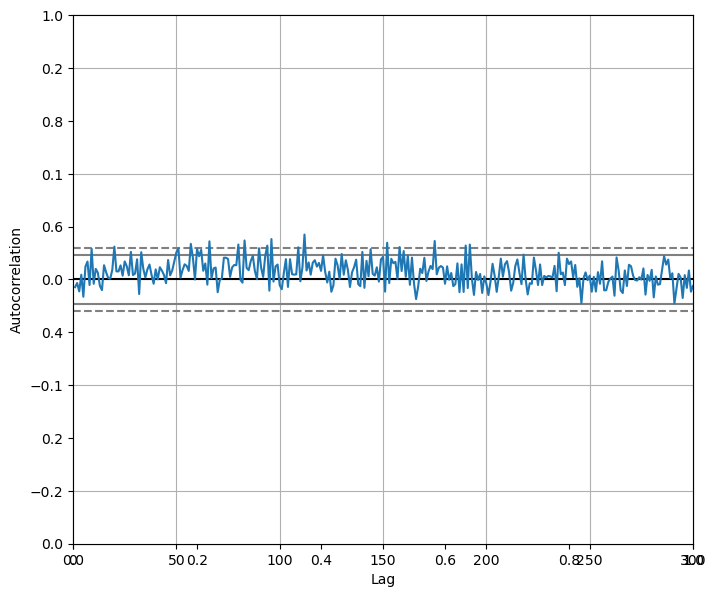

In [12]:
fig, axes = plt.subplots(figsize=(8,7), dpi= 100)
## Creating Autocorrelation plot fpr sales & lag variable
x = pd.plotting.autocorrelation_plot(df['sales'])
x.set_xlim([0, 300]); x.set_ylim(-0.25,0.25)

### Partial AutoCorrelation

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps. In simpler terms, autocorrlation represents the similarity of observations against the same observation at a past point in time - do samples in the past affect samples in the future? 

On the contrary, a partial autocorrelation denotes the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed. The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

**What is the connection between autocorrelation & partial autocorrelation?** The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps. It is these indirect correlations that the partial autocorrelation function seeks to remove. Without going into the math, this is the intuition for the partial autocorrelation and its applications to time series. 

Note below that while the ACF shows the time series has autocorrelation with the previous time period, however, PACF does not show significant partial correlation.

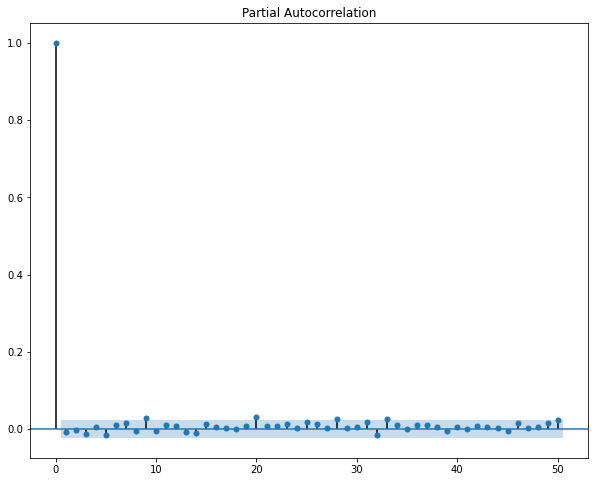

In [13]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['sales'], lags=50)
pyplot.show()

In [14]:
## split into training & testing for Time series methods
## test = ~20% of data consisting most recent dates, train = all other data
austin = austin.iloc[0:126]
test = austin.tail(1)

## Reality Check

After careful cleaning & transformation of our data, we must now consider the validity of this data and the feasibility of an model with acceptable error margins. As stated above, **the goal of this project is to attempt to predict the number of home sales in Austin,TX based on home sales prices and other factors.** We have shown above that our time series exhibits a clear upward trend with stationary behavior and consistent fluctuations of seasonality over time; therefore, we meet all requirements for common forecasting models and may proceed. If your personal data does not meet these criterion, consider options of differncing and transformations discussed above.

# Supervised Learning Models

## Rolling & Recursive-Rolling Regression 

**Rolling Regressions** are one of the simplest models for analysing changing relationships among variables overtime. They use linear regression but allow the data set used to change over time. In most linear regression models, parameters are assumed to be time-invariant and thus should not change overtime. Rolling regressions estimate model parameters using a fixed window of time over the entire data set. A larger sample size, or window, used will result in fewer parameter estimates but use more observations; to decide on the optimal window size, cross validation is a simple and efficient method. 

The size of the rolling window will depend on the sample size, T, and periodicity of the data. As a geenral rule, you can use a short rolling window size for data collected in short intervals, and a larger size for data collected in longer intervals. Longer rolling window sizes tend to yield smoother rolling window estimates than shorter sizes - for this case, we have chosen a window size of 12 in an attempt to have each iteration capture yearly data. 

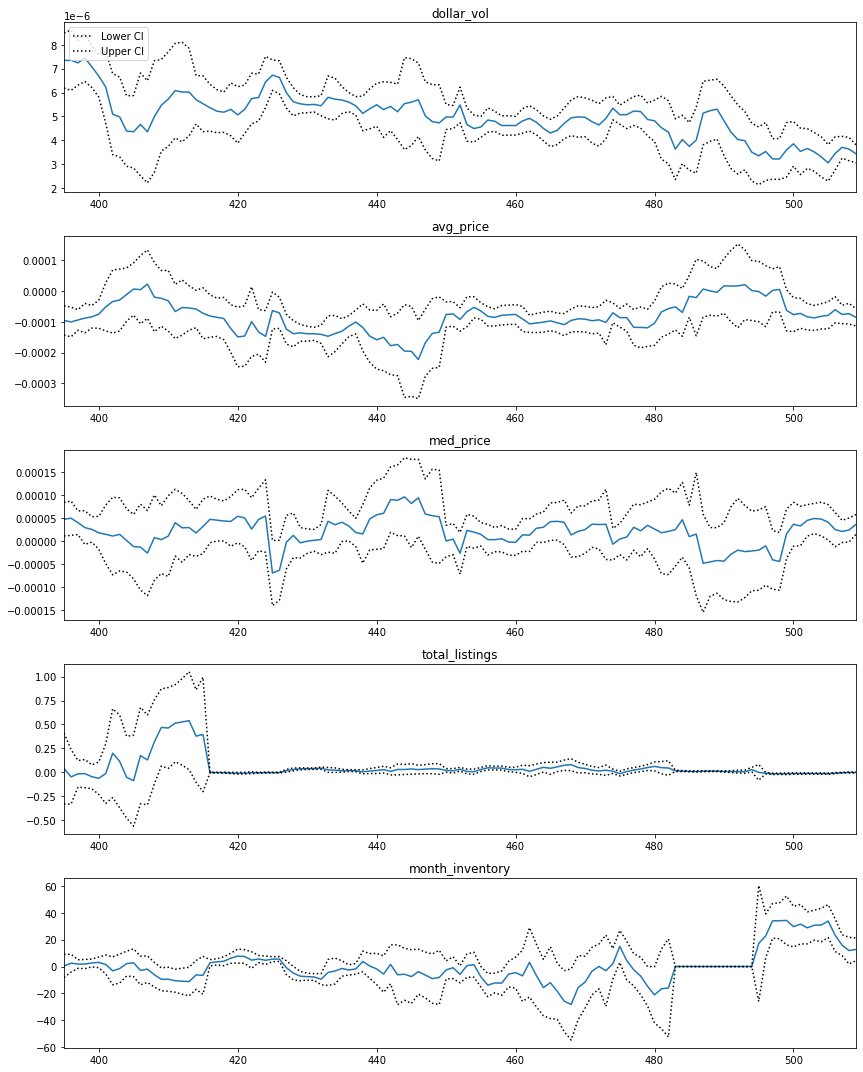

In [15]:
## Rolling regression with differing window sizes
## '-1' argument supresses model estimate for intercept
roll_reg = RollingOLS.from_formula('sales ~ dollar_vol + avg_price + med_price + total_listings + month_inventory  -1', 
    window = 12, data = austin) 

model = roll_reg.fit()

## plot of how our estimates vary over time
fig = model.plot_recursive_coefficient(alpha = 0.05 ,figsize = (12, 15))

**Recursive Rolling Regression**: A rolling regression with an expanding (rather than moving) window is effectively a recursive least squares model. We start with our desired window size, and add data as we expand outwards until we capture the whole dataset in the final step. This recursive method results in regression coefficient estimations with lower levels of variance as we are able to incorporate more data as we increasr the number of iterations.

/Users/andrewma/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


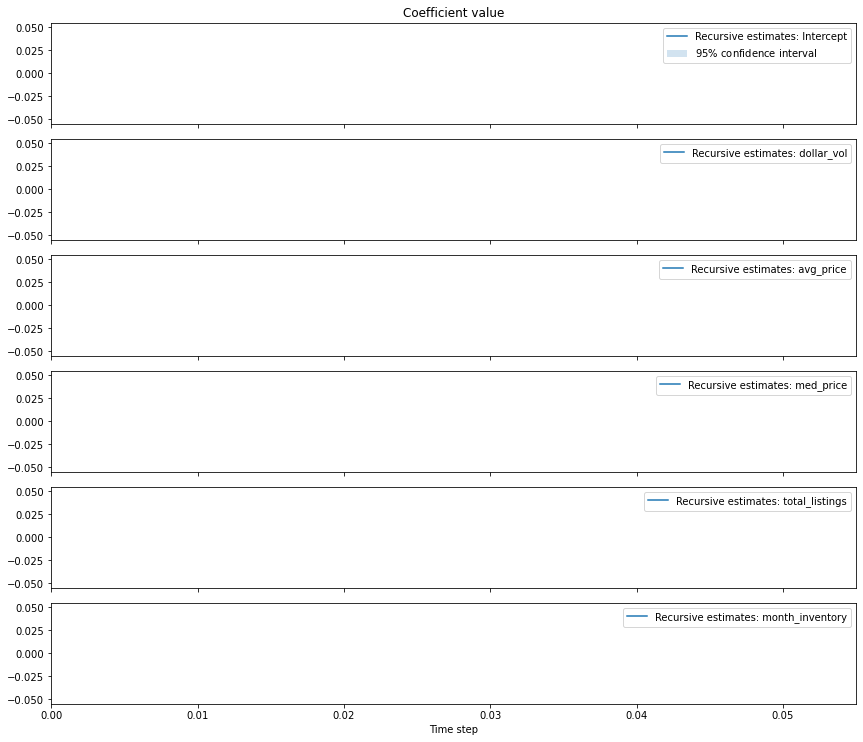

In [16]:
## Recursive ordinary least squares (expanding window rolling regression)
reg_rls = sm.RecursiveLS.from_formula(
    'sales ~ dollar_vol + avg_price + med_price + total_listings + month_inventory', austin)
model_rls = reg_rls.fit()
#print(model_rls.summary())

fig = model_rls.plot_recursive_coefficient(range(reg_rls.k_exog), legend_loc='upper right', figsize = (12,10))
ax_list = fig.axes
for ax in ax_list:
    ax.set_xlim(0, None)
ax_list[-1].set_xlabel('Time step')
ax_list[0].set_title('Coefficient value')
plt.savefig('figures/rolling-recursive')

## ARIMA Model
Next, we will be implementing an **ARIMA model** for sales number prediction; Arima is a great model for forecasting and It can be used both for seasonal and non-seasonal time series data. For non-seasonal ARIMA you have to estimate the p, d, q parameters, and for Seasonal ARIMA it has 3 more that applies to seasonal difference the P, D, Q parameters. The pipeline that we are using to run an ARIMA model is the following:

1. Look at your time series to understand if they are Seasonal or Non-Seasonal.
2. Apply differencing to time series and seasonal difference if needed to reach stationarity to get an estimate for d and D values.
3. Plot the Autocorrelation and Partial Autocorrelation plots to help you estimate the p, P, and q, Q values.
4. Fine-tune the model if needed changing the parameters according to the general rules of ARIMA


The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average. Set this to 12 to try & account for cyclical 12-month cycle of home prices

**How do we decide the hyperparameters for our ARIMA model?** This depends on the lag order derived from our ACF and PACF plots, the number of differnce equations needed to remove trend & seasonaloity, and a window size that fits the context of our problem.

I personally believe that this issue requires deeper exploration into the **hyperparmeter tuning** methods available; in the interest of simplicity for this demonstration, we will simply apply a cross-validation to find parameters resulting in the lowest RMSE scores. Other avilable options for those attempting a personal project may be an AR analysis or other statistical derivations in an attempt to find the optimal hyperparameters based on the data. 

In [17]:
## CV implementation for optimal ARIMA hyperparameters
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset['sales'].astype('float32')
	best_score, best_cfg = float("100000"), (0,0,0)
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				model = ARIMA(austin['sales'], order)
				model_fit = model.fit()
				rmse = model_fit.aic
				print(rmse)
				if rmse < best_score:
					best_score, best_cfg = rmse, order
				print('ARIMA%s RMSE=%.3f' % (order,rmse))
					

	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

  # evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 2)
warnings.filterwarnings("ignore")

evaluate_models(austin, p_values, d_values, q_values)

853.9193048536289
ARIMA(0, 0, 0) RMSE=853.919
844.2822495178712
ARIMA(0, 0, 1) RMSE=844.282
876.0058885214345
ARIMA(0, 1, 0) RMSE=876.006
832.5455878437602
ARIMA(0, 1, 1) RMSE=832.546
999.7300013994304
ARIMA(0, 2, 0) RMSE=999.730
876.854108454638
ARIMA(0, 2, 1) RMSE=876.854
838.6757606618887
ARIMA(1, 0, 0) RMSE=838.676
836.3918733666314
ARIMA(1, 0, 1) RMSE=836.392
849.4104410888193
ARIMA(1, 1, 0) RMSE=849.410
829.0824695729304
ARIMA(1, 1, 1) RMSE=829.082
926.7443172685116
ARIMA(1, 2, 0) RMSE=926.744
851.2255240981019
ARIMA(1, 2, 1) RMSE=851.226
835.250940720613
ARIMA(2, 0, 0) RMSE=835.251
837.2488871128428
ARIMA(2, 0, 1) RMSE=837.249
847.6681919163948
ARIMA(2, 1, 0) RMSE=847.668
828.0377662110304
ARIMA(2, 1, 1) RMSE=828.038
897.8753706250623
ARIMA(2, 2, 0) RMSE=897.875
849.82202389396
ARIMA(2, 2, 1) RMSE=849.822
837.2470347589863
ARIMA(3, 0, 0) RMSE=837.247
833.4140416416699
ARIMA(3, 0, 1) RMSE=833.414
849.1855716386176
ARIMA(3, 1, 0) RMSE=849.186
829.8674739636117
ARIMA(3, 1, 1) RMSE=

With an RMSE score of 828, it seems that ARIMA is not providing acceptable predicitions; this suggests that there may be other factors affecting our data that ARIMA cannot accoiunt for. For further exploration, Seasonal ARIMA captures historical values, shock events and seasonality, and may provide better predicitons of home sales. This result actually mathces our intuition - note that there are large fluctuations around 2008 & 2020 as a result of global shock events that may induce large amounts of bias into our model.

In [83]:
## ARIMA(Autoregressive Integrated Moving Average) implementation
## fitting ARIMA model with optimal paramters 1,1,0
model = ARIMA(austin['sales'], order=(2,1,1))
model_fit = model.fit()

## Auto Arima to find ARIMA model returning lowest AIC score
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                  125
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -409.019
Method:                       css-mle   S.D. of innovations              6.280
Date:                Tue, 15 Mar 2022   AIC                            828.038
Time:                        23:31:13   BIC                            842.179
Sample:                             1   HQIC                           833.783
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0740      0.025      2.960      0.003       0.025       0.123
ar.L1.D.sales     0.2383      0.090      2.648      0.008       0.062       0.415
ar.L2.D.sales     0.1585      0.090     

## Non Linear Effects - Generalized Additive Models

**So if the classic ARIMA model does not provide desirable predictions; where can we look to next?** If we suspect the data is having a nonlinear effect, we may implement GAMs. Linearity in models means that the changes of one unit in predictors can cause the same effect on the outcome of the model. If at some point, changes in feature not affecting the outcome or impacting oppositely, we can say that there is a nonlinearity effect in the data.

Due to the non-Gaussian distribution of our target variable 'number of home sales', I suspect that a GAM model with polynomials will product much better predictions and accuracy when compared to the regression methdos above. `gam.gridsearch(X_train, y_train)` will return optimal hyperparames for this scenario. 

In [113]:
## optimal GAM hyperparameters
X = austin[features].values; y = austin[target].values
gam = LinearGAM(f(0) + s(1) + s(2) + s(3)).gridsearch(X, y)

## Generalized Additive Models (GAM)
## Generalized Additive Models allow for penalized estimation of smooth terms in generalized linear models
gam.summary()
XX = gam.generate_X_grid(term=0, n=500)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:02
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:01
 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:01
 45% (5 of 11) |###########              | Elapsed Time: 0:00:01 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:01
 63% (7 of 11) |###############          | Elapsed Time: 0:00:01 ETA:   0:00:01
 72% (8 of 11) |##################       | Elapsed Time: 0:00:02 ETA:   0:00:00
 81% (9 of 11) |####################     | Elapsed Time: 0:00:02 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:02 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     95.5238
Link Function:                     IdentityLink Log Likelihood:                                    -34.877
Number of Samples:                          126 AIC:                                              262.8017
                                                AICc:                                             923.9422
                                                GCV:                                               24.6574
                                                Scale:                                               0.384
                                                Pseudo R-Squared:                                   0.9981
Feature Function                  Lam

From the results above, we see a satisfactory AIC score of ~300. Furthermore, the table tells us that "month_inventory" has a compartively larger effect than other covariates such as averae price on the number of home sales. This agrees with the result we found above with the ARIMA model; of course, this was a simple GAM shown with 3 linear components and 1 polynomial after a quick grid-search - further research into optimal functions for our covariates must be done in any serious personal research or paper publications. Note that our predictions below seem to fall consistently below the actual test data, with the samples appearing near the top edge of our 95% confidence interval, implying that we need to reconsider our hyper-parameters or there is simply insufficient amounts of data for accurate predictions.

Text(0.5, 1.0, '95% prediction interval')

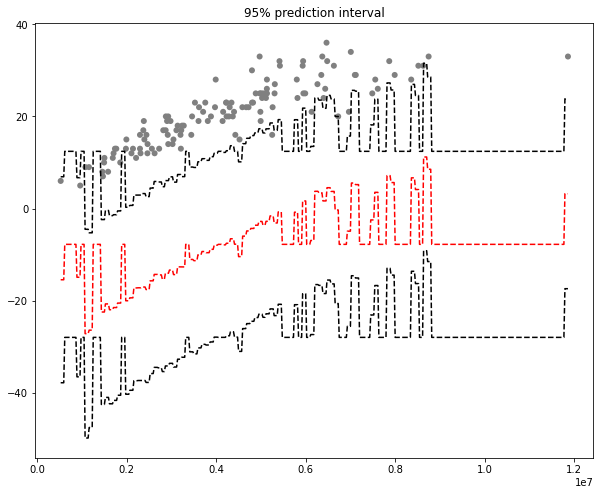

In [115]:
## GAM-model plot
plt.plot(XX[XX!=0], gam.predict(XX), 'r--')
gam.prediction_intervals(XX, width=.95)
plt.plot(XX[XX!=0], gam.prediction_intervals(XX, width=.95), color='black', ls='--')

plt.scatter([i[0] for i in X], y, facecolor='gray', edgecolors='none')
plt.title('95% prediction interval')

# Findings & Discussion

## Findings

Cirlcing back to the original question: what affects the number of home sales in Austin, Texas? From the models above, we can conclude a couple of things:

- The number of home sales in Austin,TX is most affected by the amount of available inventory for that month
- Surprisingly, the effects of home prices are negligable when attempting to predict the number of sales
- There exists non-negligable amounts of correlation between the number of sales against time - once again, this would be worth exploring deeper in terms of model hyperparameters

## Discussion
As stated above, many time-indexed methods suffer from the lack of global information available; for example, the number of house sales is dependent on the time of the year, but may also be affected or correlated to other variables such as the current economic health, federal interest rates, house market safety scores, etc. To this end, there has already been research into proper implementation and introduction of time-independent covariates into time series models.

Another line of development in time series, originating from Box-Jenkins models, are the non-linear generalizations, mainly ARCH (AutoRegressive Conditional Heteroscedasticity)and GARCH(Generalized ARCH) models. These models allow for the parameterization and prediction of heteroskedastic variance & have thus proved very useful for finance-focused time series analysis, where volatility and time-depndent variances must be taken into account. In fact, the invention of them and the launch of the error correction model gave C. W. J Granger and R. F. Engle the Nobel Memorial Prize in Economic Sciences in 2003; today, both avenues of coavariate analysis & variance assumptions are at the forefront of research towards newer & more statistically powerful methods.

## Taking it Further

For further self-study on time series and applicable methods, I would recommend the following resources:

* P., Cowpertwait Paul S, and Andrew V. Metcalfe. Introductory Time Series with R. Springer, 2009. 
* Hamilton, James Douglas. Time Series Analysis, Springer, 1994
* Hyndman, Rob. Forecasting: Principles & Practice 2nd. Edition, OText, 2018

Other resources including lecture notes and online materials may be found in the  *References* list below!

# References

1. Business, Fuqua School of. “Identifying the Numbers of AR or MA Terms in an ARIMA Model.” Identifying the Orders of Ar and MA Terms in an Arima Model, http://people.duke.edu/~rnau/411arim3.htm. 
2. “Gam Model : Pygam Package Details Analysis and Possible Issue Resolving.” GAM Model : PyGAM Package Details Analysis and Possible Issue Resolving, https://shyambhu20.blogspot.com/2020/07/gam-model-pygam-package-details.html.
3. Lithmee. “Difference between Time Series and Cross Sectional Data.” Compare the Difference Between Similar Terms, Differencebetween.com, 10 June 2018, https://www.differencebetween.com/difference-between-time-series-and-cross-sectional-data/. 
4. Nielsen, Aileen. “Practical Time Series Analysis.” O'Reilly Online Learning, O'Reilly Media, Inc., https://www.oreilly.com/library/view/practical-time-series/9781492041641/ch01.html. 
5. Zoubir, Leila. “Time Series Analysis.” Svensk Webbplats, https://www.statistics.su.se/english/research/time-series-analysis/a-brief-history-of-time-series-analysis-1.259451. 